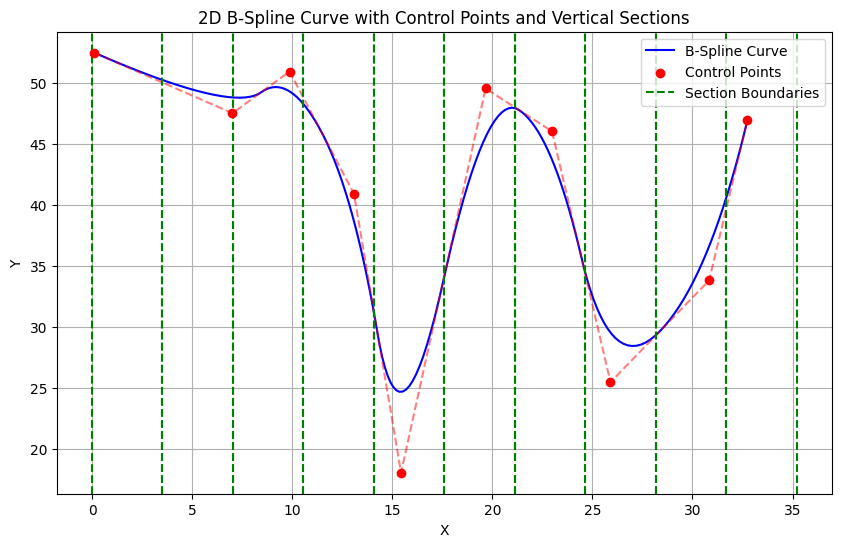

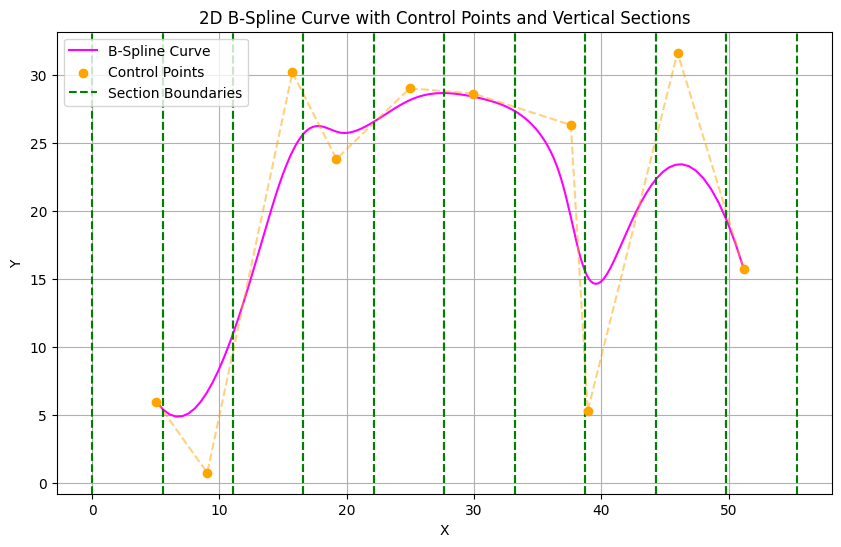

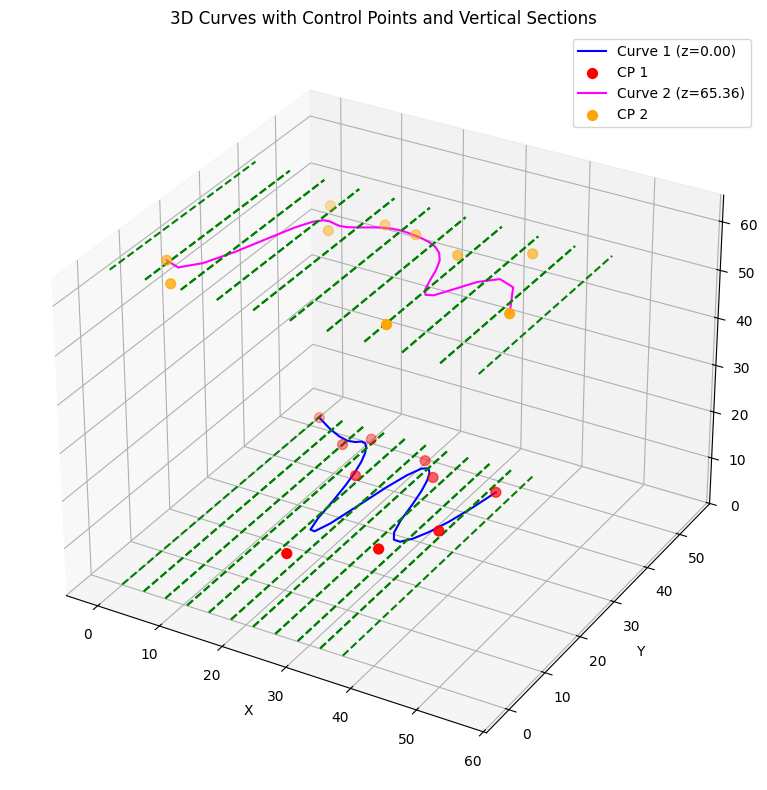

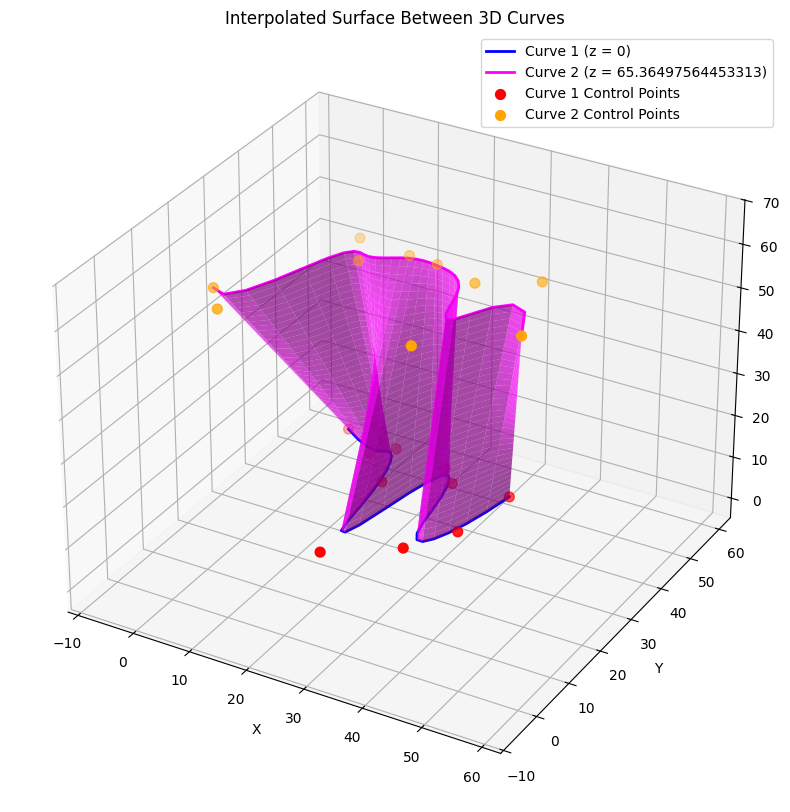

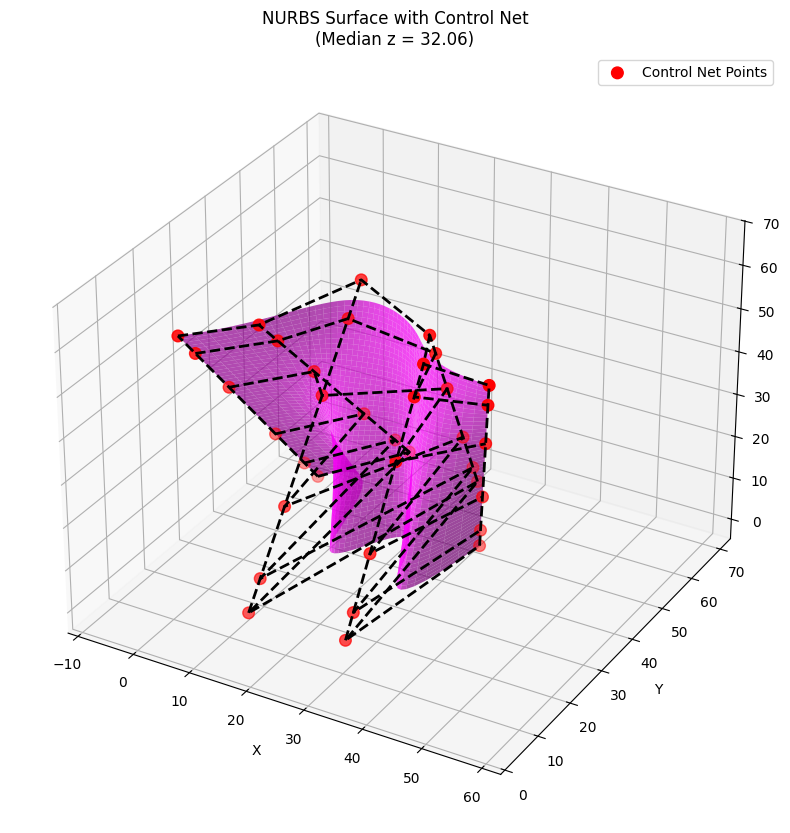

Created a dataset entry.
{'rotated_noisy_points': array([[[ 65.68549466,  27.75989184,  20.09103555],
        [ 66.19783317,  31.26031679,  20.33645367],
        [ 66.13196384,  32.88578746,  21.31332544],
        ...,
        [ 49.30612539,  31.70724529,  51.7822835 ],
        [ 51.78552153,  36.12135198,  50.10041799],
        [ 54.68754501,  42.59054429,  47.77617224]],

       [[ 63.33112069,  27.45918963,  20.17695672],
        [ 63.93714797,  30.56341725,  19.8447922 ],
        [ 64.46200739,  32.57878496,  21.12741666],
        ...,
        [ 47.7915799 ,  31.59897736,  51.4498175 ],
        [ 49.79784974,  36.36865361,  49.85648844],
        [ 52.57509461,  42.71781925,  47.84283256]],

       [[ 61.34281644,  26.88437854,  19.69818293],
        [ 61.82691499,  30.20056503,  20.07076153],
        [ 61.83726397,  32.0202047 ,  21.1355604 ],
        ...,
        [ 46.06379107,  31.91145105,  51.0353123 ],
        [ 47.8196794 ,  36.4955471 ,  49.73843479],
        [ 50.29955681, 

In [9]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.utils import register_keras_serializable

# Project-specific modules (make sure these are on your PYTHONPATH)
import DatasetGenerator  # assuming your module is named DatasetGenerator.py
import surface_compare
import nurbs_vis  # if you use it elsewhere

# ── GPU selection (optional) ─────────────────────────────────────────────
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# ── Create a single dataset entry using the provided parameter list ─────
entry = DatasetGenerator.create_dataset_entry(
    num_points_range=(3, 10),       # Range for number of control points per 2D curve
    plane_width_range=(20, 60),    # 2D plane width range
    plane_height_range=(20, 60),    # 2D plane height range
    num_samples=35,                 # Number of samples along the curves for interpolation
    num_v=35,                       # Number of interpolation steps between curves
    noise_std=0.15,                 # Std dev for added Gaussian noise
    noise_mean=0.15,                # Mean for the added noise
    degree_u=3,                     # Degree in the u-direction for the NURBS surface
    degree_v=3,                     # Degree in the v-direction for the NURBS surface
    ctrlpts_size_u_range=(4, 8),    # Range for # control points in u-direction
    ctrlpts_size_v_range=(4, 8),    # Range for # control points in v-direction
    z_gap_range=(20, 80),          # Range for the z-gap between curves
    bspline_degree=3,               # Degree for creating the B-spline curves
    extrapolate=False,              # Whether to allow B-spline extrapolation
    random_rotation=True,
    normalise=False,
    show_visu=True                  # Enable visualization of intermediate steps
)

print("Created a dataset entry.")
print(entry)
print("Rotation angles (radians):", entry["rotation_angle"])
print("Z-gap between curves:", entry["z_gap"])

# ── Prepare input points tensor for the model ───────────────────────────
points = np.reshape(entry["rotated_noisy_points"], (-1, 3))
points = np.expand_dims(points, axis=0)  # (B=1, N, 3)
print("Input points shape:", points.shape)

In [10]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.utils import register_keras_serializable

# Project-specific modules (make sure these are on your PYTHONPATH)
import DatasetGenerator  # assuming your module is named DatasetGenerator.py
import surface_compare
import nurbs_vis  # if you use it elsewhere

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


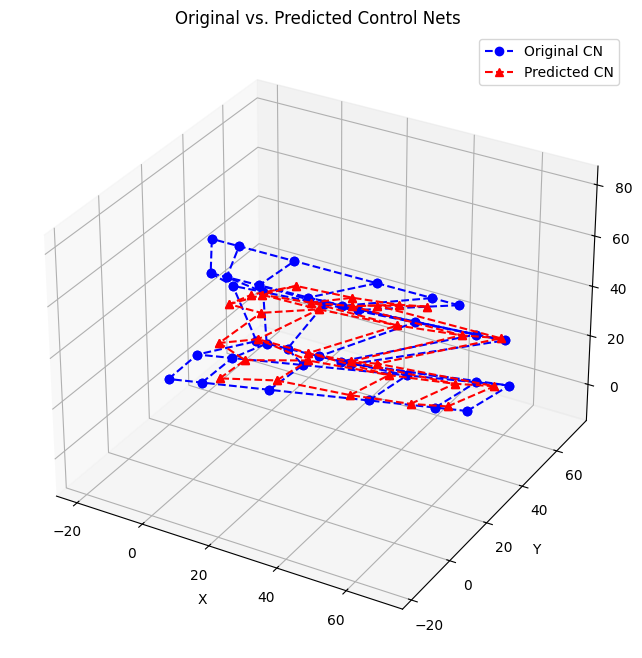

Predicted control net shape: (5, 6, 3)
Ground-truth control net shape: (6, 6, 3)


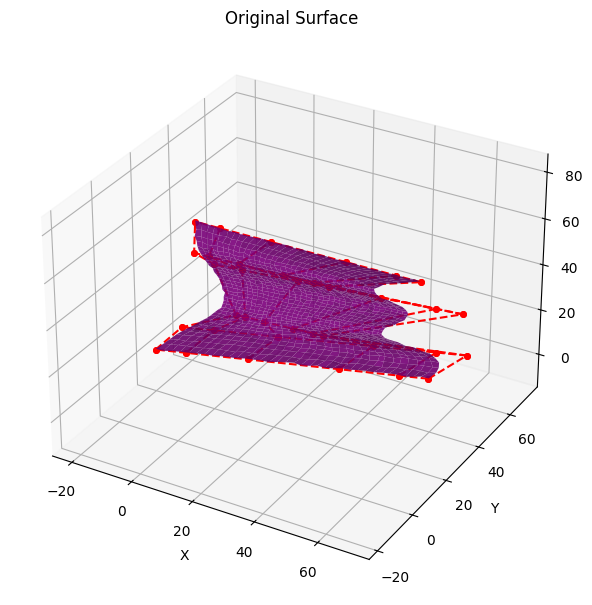

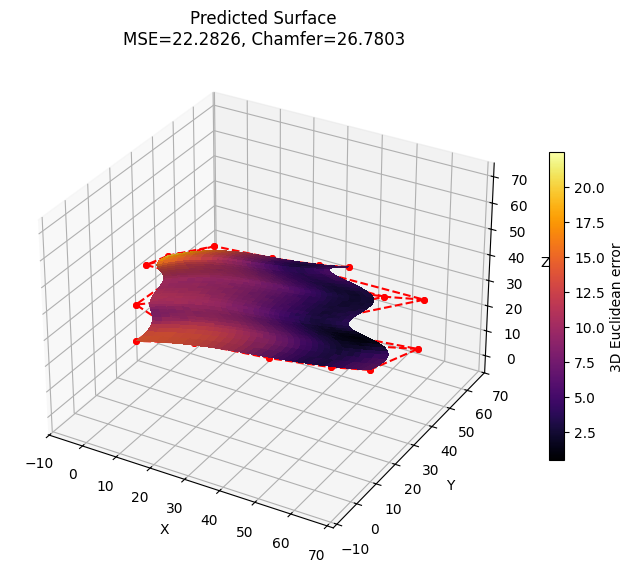

|   mse_surface |   chamfer_surface |   mse_ctrl_net |   chamfer_ctrl_net |
|--------------:|------------------:|---------------:|-------------------:|
|     22.282630 |         26.780306 |      18.373170 |          85.442659 |
Shapes:
  Approximated CN : (6, 6, 3)
  Predicted CN    : (5, 6, 3)
  Original CN     : (6, 6, 3)
MSE  (Predicted  CN vs Original): 18.373170
MSE  (Approximated CN vs Original): 1.337068
Chamfer (Predicted  CN vs Original): 85.442659
Chamfer (Approximated CN vs Original): 8.022406
MSE  (Predicted  Surface vs Original): 22.282630
MSE  (Approximated Surface vs Original): 0.481077
Chamfer (Predicted  Surface vs Original): 26.780306
Chamfer (Approximated Surface vs Original): 0.934061


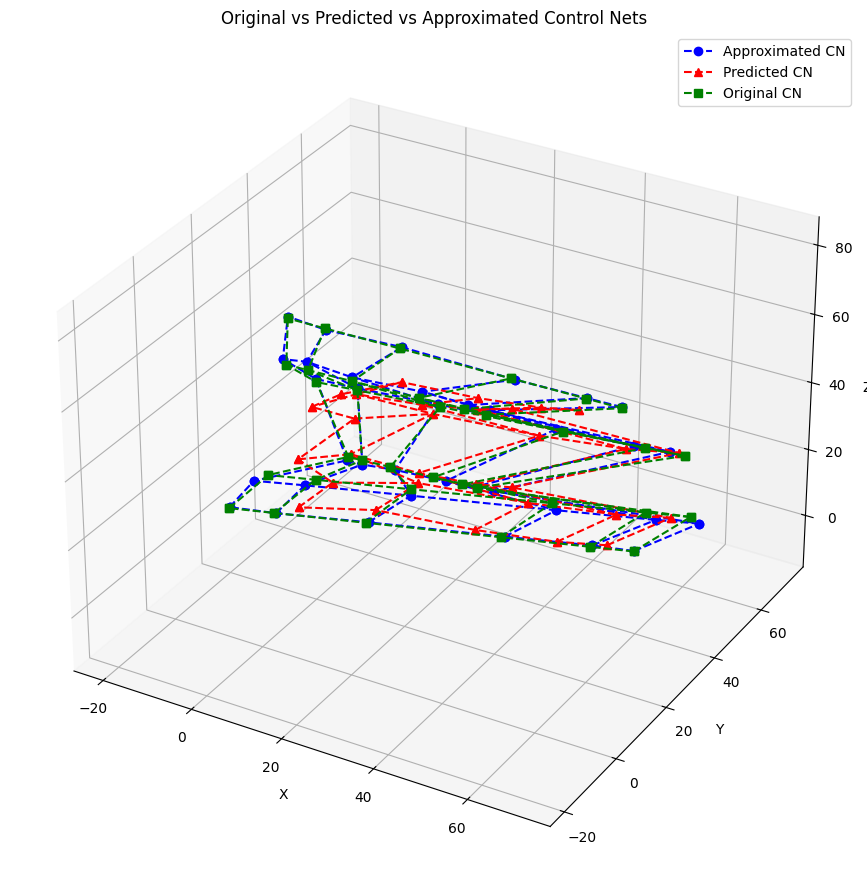

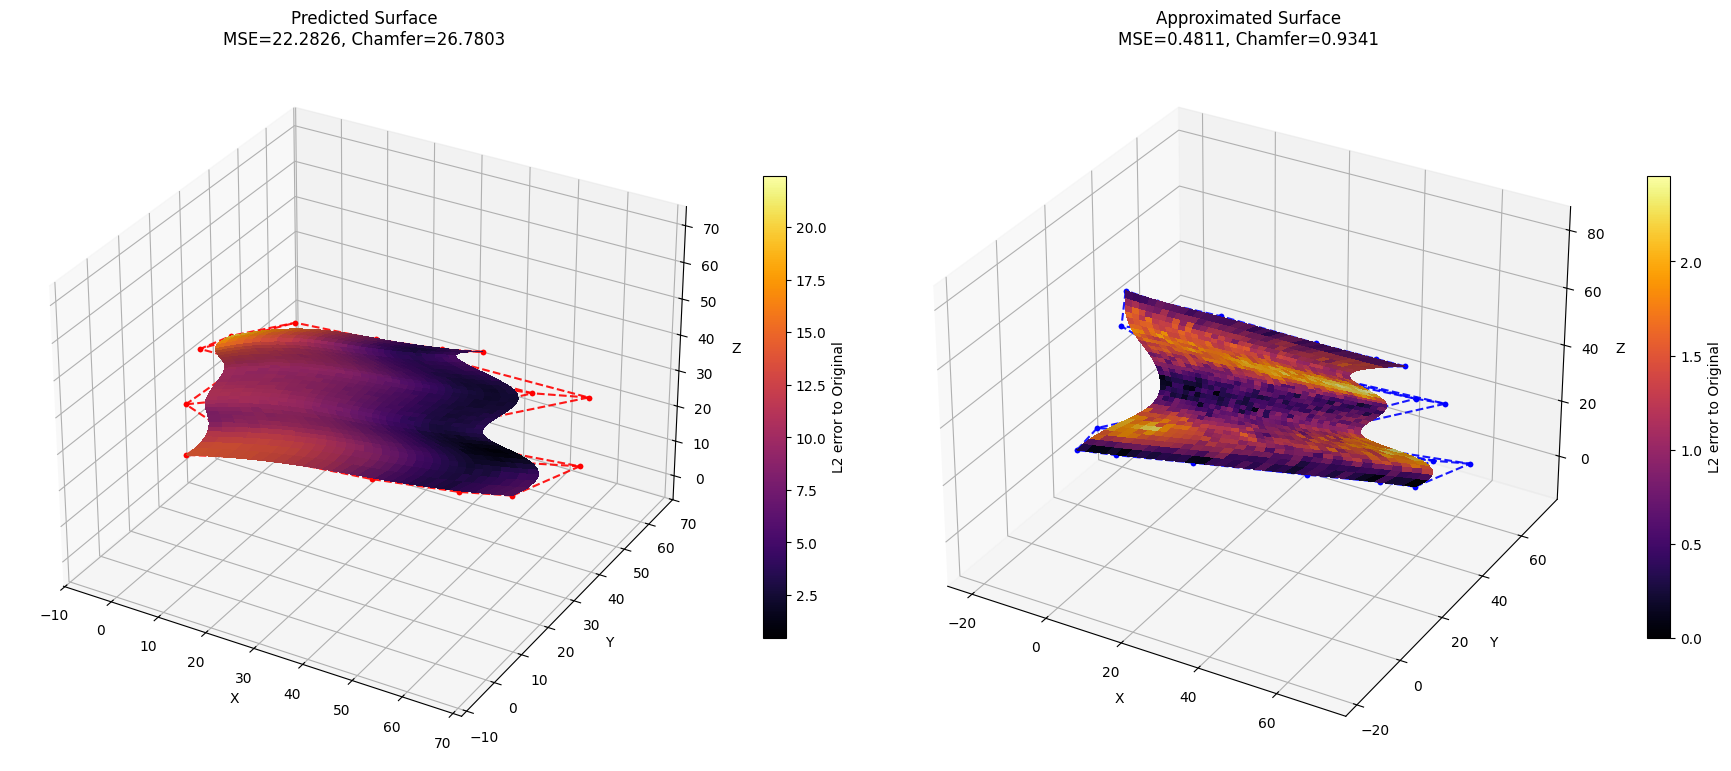

{'mse_ctrl_net_predicted': 18.373169644639642,
 'mse_ctrl_net_approximated': 1.3370676013485456,
 'chamfer_ctrl_net_predicted': 85.44265854253496,
 'chamfer_ctrl_net_approximated': 8.02240560809127,
 'mse_surface_predicted': 22.28263041375893,
 'mse_surface_approximated': 0.4810769437747474,
 'chamfer_surface_predicted': 26.780306192869237,
 'chamfer_surface_approximated': 0.934061054464151}

In [11]:
# ── Helper: channel-wise Laplacian (4-neighbour) ────────────────────────
def laplacian(grid):
    """
    grid : (B, H, W, C) tensor – C = 3 for (x,y,z)
    returns channel-wise 4-neighbour Laplacian with SAME shape.
    """
    lap_k = tf.constant(
        [[0, 1, 0],
         [1, -4, 1],
         [0, 1, 0]],
        tf.float32
    )  # (3,3)
    lap_k = lap_k[..., tf.newaxis, tf.newaxis]  # (3,3,1,1)

    C = tf.shape(grid)[-1]  # channel count at run-time
    lap_k = tf.tile(lap_k, [1, 1, C, 1])  # (3,3,C,1)

    return tf.nn.depthwise_conv2d(
        grid, lap_k,
        strides=[1, 1, 1, 1],
        padding='SAME'
    )  # (B,H,W,C)

# ── Custom loss (MSE + Laplacian consistency) ───────────────────────────
@register_keras_serializable(package='CustomLosses', name='total_loss')
def total_loss(y_true, y_pred, w_lap=0.05):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    lap = tf.reduce_mean(tf.square(laplacian(y_true) - laplacian(y_pred)))
    return mse + w_lap * lap

# ── (Optional) Load a dataset entry from file if you want instead of generating ─
# dataset_file = "dataset/dataset_10_surfaces_noise0.0_2109_1704.pkl"
# with open(dataset_file, "rb") as f:
#     entry = pickle.load(f)
# points = np.reshape(entry["rotated_noisy_points"], (-1, 3))
# points = np.expand_dims(points, axis=0)

# ── Load trained model (make sure path exists) ──────────────────────────
model_path = "models/pointnet_surface_20250618_1830_100ep.keras"
model = tf.keras.models.load_model(model_path, custom_objects={'total_loss': total_loss})

# ── Predict control net ─────────────────────────────────────────────────
predicted_ctrl_net = model.predict(points)

# Post-process prediction (project-specific)
predicted_ctrl_net = surface_compare.remove_negative_and_shrink_control_net(predicted_ctrl_net)

# ── Compare predicted vs. ground-truth control nets ─────────────────────
surface_compare.compare_control_nets_in_one_plot(
    entry["rotated_control_net"],
    predicted_ctrl_net
)

# ── Report shapes ───────────────────────────────────────────────────────
print("Predicted control net shape:", predicted_ctrl_net.shape)
print("Ground-truth control net shape:", entry["rotated_control_net"].shape)




metrics = surface_compare.compare_surfaces(entry, predicted_ctrl_net, num_samples=50, show_control_net=True)

# Convert to a structured DataFrame
df_metrics = pd.DataFrame([metrics])

# Display in an interactive table
print(df_metrics.to_markdown(index=False, floatfmt=".6f"))



surface_compare.compare_approximated_control_nets_new(
    original_entry=entry,
    predicted_ctrl_net= predicted_ctrl_net,
    degree_u=3,       # Adjust as in your data generation settings
    degree_v=3
    # ctrlpts_size_u and ctrlpts_size_v are automatically derived from predicted_ctrl_net's shape (e.g., 4, 7)
)


start


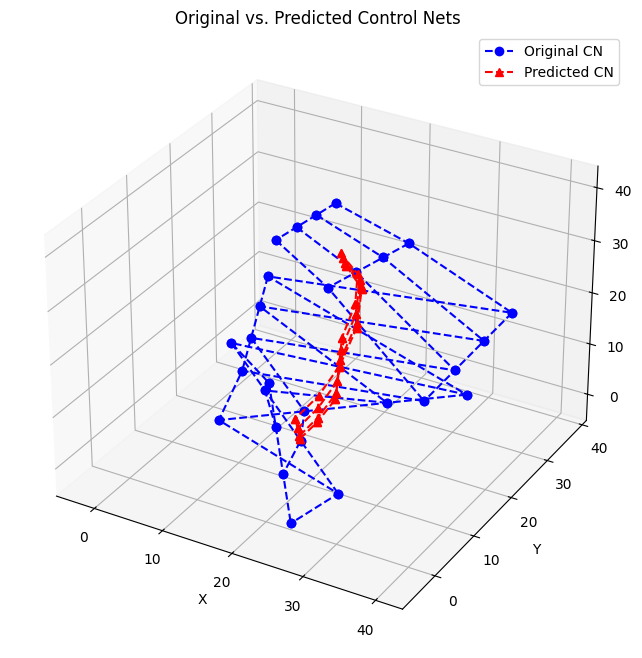

Predicted control net shape: (4, 7, 3)
Ground-truth control net shape: (4, 7, 3)


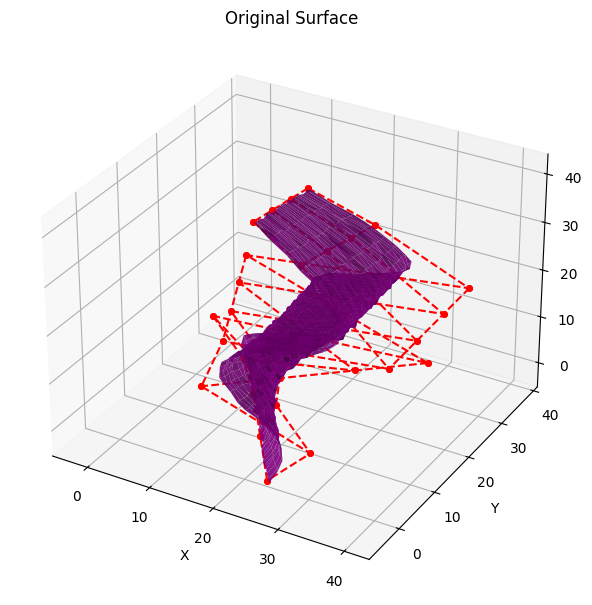

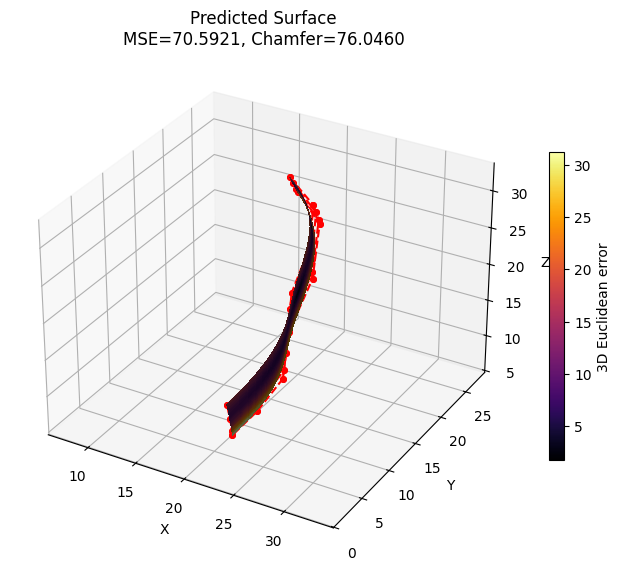

|   mse_surface |   chamfer_surface |   mse_ctrl_net |   chamfer_ctrl_net |
|--------------:|------------------:|---------------:|-------------------:|
|     70.592069 |         76.045993 |     128.525882 |         224.596703 |
Shapes:
  Approximated CN : (4, 7, 3)
  Predicted CN    : (4, 7, 3)
  Original CN     : (4, 7, 3)
MSE  (Predicted  CN vs Original): 128.525882
MSE  (Approximated CN vs Original): 1.836145
Chamfer (Predicted  CN vs Original): 224.596703
Chamfer (Approximated CN vs Original): 11.016872
MSE  (Predicted  Surface vs Original): 70.592069
MSE  (Approximated Surface vs Original): 1.541672
Chamfer (Predicted  Surface vs Original): 76.045993
Chamfer (Approximated Surface vs Original): 0.854510


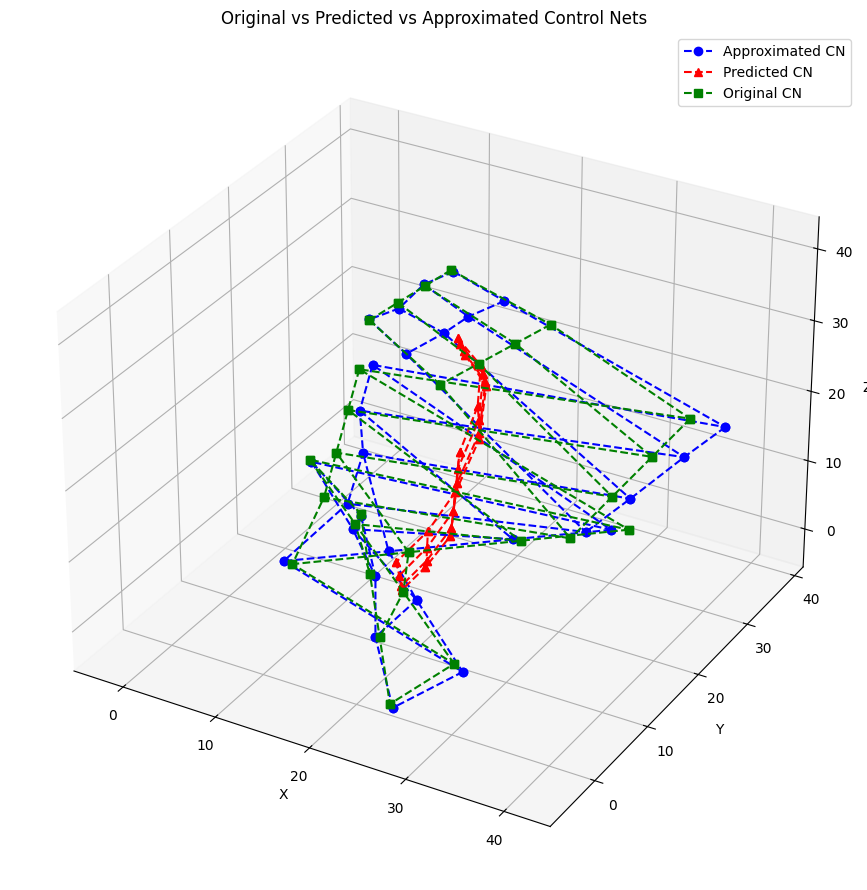

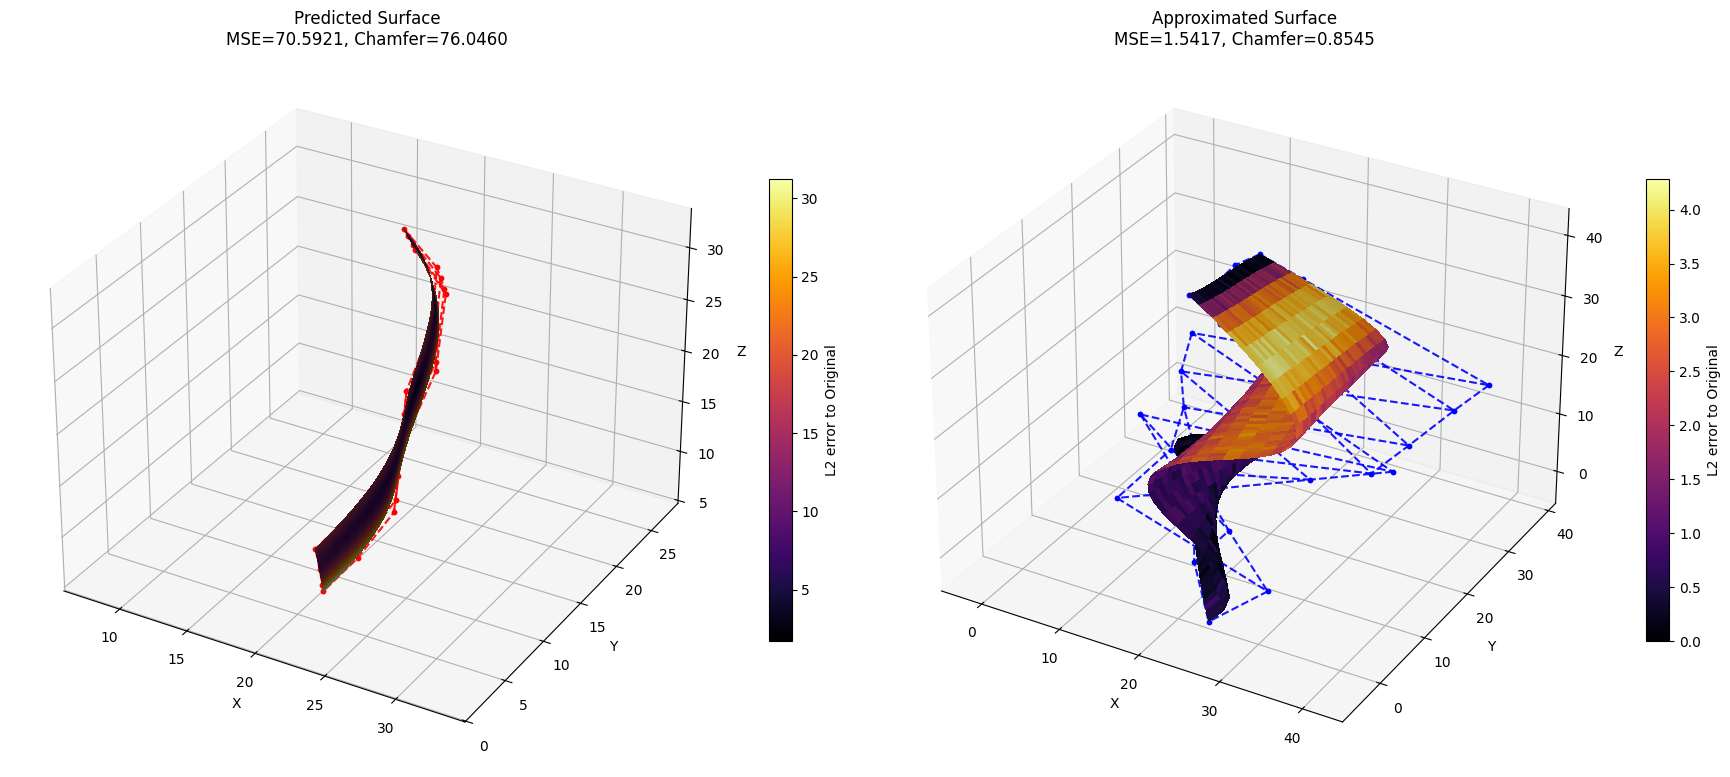

{'mse_ctrl_net_predicted': 128.5258818135529,
 'mse_ctrl_net_approximated': 1.8361452916833716,
 'chamfer_ctrl_net_predicted': 224.59670278464608,
 'chamfer_ctrl_net_approximated': 11.016871750100233,
 'mse_surface_predicted': 70.59206887181509,
 'mse_surface_approximated': 1.541671858942108,
 'chamfer_surface_predicted': 76.04599281035644,
 'chamfer_surface_approximated': 0.8545101815230594}

In [3]:
import pickle
print("start")

dataset_file = "dataset/good_entry_1.pkl"

with open(dataset_file, "rb") as f:
    entry = pickle.load(f)


#points = np.reshape(entry["rotated_noisy_points"], (-1, 3))
#points = np.expand_dims(points, axis=0)  # (B=1, N, 3)
#print("Input points shape:", points.shape)


import os
# If you've had CUDA device errors, uncomment to force CPU:
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

import torch
import numpy as np
import pandas as pd

import surface_compare
import train_pointnet_surface_torch_fa as pointnet  # provides PointNet2SurfaceRegressor

device = torch.device("cuda")


# ---- prepare input ------------------------------------------------------
# Expecting `entry` in scope. If `points` isn't already (1, N, 3), rebuild from entry.
if "points" not in globals() or not isinstance(points, np.ndarray) or points.ndim != 3 or points.shape[-1] != 3:
    points = np.reshape(entry["rotated_noisy_points"], (-1, 3))
    points = np.expand_dims(points, axis=0).astype(np.float32)  # (1, N, 3)

# Convert to torch and layout for Conv1d(in_channels=3)
# Convert to torch but keep (B, N, 3); let the model transpose internally.
x = torch.from_numpy(points).float().contiguous()  # shape: (B, N, 3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = x.to(device)


# ---- checkpoint paths ---------------------------------------------------
model_path = "models/pointnet_surface_20250823_0201_100ep.pt"
# NOTE: .h5 is a Keras checkpoint and cannot be loaded by PyTorch directly.
weights_path = "models/best_pointnet_surface_100.weights.h5"

# ---- utility: strip 'module.' from DataParallel checkpoints ------------
from collections import OrderedDict

def strip_module_prefix(state_dict):
    if any(k.startswith("module.") for k in state_dict.keys()):
        return OrderedDict((k.replace("module.", "", 1), v) for k, v in state_dict.items())
    return state_dict

# ---- load state dict (handles common wrapper dicts) ---------------------
ckpt = torch.load(model_path, map_location="cpu")  # load to CPU first; safer
#ckpt = torch.load(weights_path, map_location="cpu")  # load to CPU first; safer


if isinstance(ckpt, dict) and "state_dict" in ckpt:
    state_dict = ckpt["state_dict"]
elif isinstance(ckpt, dict):
    state_dict = ckpt
else:
    raise RuntimeError(f"Checkpoint is not a state_dict-like dict; got type: {type(ckpt)}")

state_dict = strip_module_prefix(state_dict)

# ---- build model, load weights -----------------------------------------
model = pointnet.PointNet2SurfaceRegressor()
load_info = model.load_state_dict(state_dict, strict=False)  # tolerate BN tracking keys etc.
if load_info.missing_keys:
    print("[load_state_dict] missing keys:", load_info.missing_keys)
if load_info.unexpected_keys:
    print("[load_state_dict] unexpected keys:", load_info.unexpected_keys)

model = model.to(device).eval()

# ---- predict ------------------------------------------------------------
with torch.no_grad():
    y = model(x)  # shape depends on your model head
predicted_ctrl_net = y.detach().cpu().numpy()

# ---- post-process + visualize ------------------------------------------
predicted_ctrl_net = surface_compare.remove_negative_and_shrink_control_net(predicted_ctrl_net)

surface_compare.compare_control_nets_in_one_plot(
    entry["rotated_control_net"],
    predicted_ctrl_net
)

print("Predicted control net shape:", predicted_ctrl_net.shape)
print("Ground-truth control net shape:", entry["rotated_control_net"].shape)

metrics = surface_compare.compare_surfaces(entry, predicted_ctrl_net, num_samples=50, show_control_net=True)
df_metrics = pd.DataFrame([metrics])
print(df_metrics.to_markdown(index=False, floatfmt=".6f"))

surface_compare.compare_approximated_control_nets_new(
    original_entry=entry,
    predicted_ctrl_net=predicted_ctrl_net,
    degree_u=3,
    degree_v=3
)


In [13]:
    if False:
        filename = f"good_entry_2.pkl"
        save_dir = f"dataset"
        file_path = os.path.join(save_dir, filename)
        with open(file_path, "wb") as f:
            pickle.dump(entry, f)
        print("Saved")